In [88]:
#import python packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from scipy.signal import argrelextrema
#import scipy as sp
from scipy.signal import find_peaks
from scipy.signal import peak_widths
import peakutils

In [2]:
#assign filename variable
#example input: 2018_08_22_Myometrial_Contractility_Study_4_MB_1_8.tsv
filename = input("Input filename:" )
#assign variable for excel reference file
ref_filename = "./Myometrial Contractility Reference.txt"
#assign variable for comments file
comments_filename = filename[0:-4] + "_comments" + ".txt"

Input filename:2018_08_22_Myometrial_Contractility_Study_4_MB_1_8.tsv


In [3]:
#importing files and processing
#import muscle bath tsv file
df_file = pd.read_csv(filename, sep='\t')
#import data from excel reference file
df_ref = pd.read_csv(ref_filename, sep='\t')
#import corresponding comments file
comments_file = open(comments_filename,'r')
#process comments
cment_time = []
cment_txt = []
for line in comments_file:
    line = line.rstrip()
    line = line.split(sep = '\t')
    cment_time.append(line[0])
    cment_txt.append(line[1])
#drop unneccessary columns from muscle bath force file
df_file = df_file.drop(columns=['Timestamp','Stimulus'])
#set experiment time as index
df_file.set_index('Experiment Time', inplace = True)
#find filename in reference dataframe
df_ref = df_ref[df_ref['Filename'] == filename]
#drop extra columns
df_ref = df_ref[df_ref.columns[0:14]]
#check to see if muscle bundle should be excluded
df_ref = df_ref[df_ref["EXCLUDE SAMPLE"] != 1]
#reset df_ref index, starting at 0
#this enables easier indexing
df_ref.set_index([pd.Index(list(range(len(df_ref))))])

,Filename,Study,Patient,Bath Number,Patient Status,Pitocin,Amount (ml),Treatment,Conc. (ng/ml),Length (mm),Width1(mm),Width2(mm),Mass (mg),EXCLUDE SAMPLE
0,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,1,NaN,1.0,0.05,Adiponectin,100.0,28.21,1.78,2.00,100.0,NaN
1,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,2,NaN,0.0,0.00,TNF_alpha,10.0,22.77,1.99,2.84,100.0,NaN
2,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,3,NaN,1.0,0.05,Control,NaN,23.82,1.98,1.68,46.0,NaN
3,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,4,NaN,0.0,0.00,Adiponectin,100.0,32.81,2.98,1.65,130.0,NaN
4,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,5,NaN,1.0,0.05,TNF_alpha,10.0,25.07,3.16,1.68,108.0,NaN
5,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,6,NaN,0.0,0.00,Control,NaN,24.31,1.72,2.53,85.0,NaN
6,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,7,NaN,1.0,0.05,Adiponectin,100.0,28.13,2.77,1.31,66.0,NaN
7,2018_08_22_Myometrial_Contractility_Study_4_MB...,4,SO5,8,NaN,0.0,0.00,TNF_alpha,10.0,28.24,1.73,1.68,72.0,NaN


In [12]:
#print comments with timepoints
for counter, value in enumerate(cment_time):
    print(cment_txt[counter],":",value)
#create a list of the column names where muscle bath force values are stored
Force_list = ["Force1","Force2","Force3","Force4","Force5","Force6","Force7","Force8"]
#create a placeholder list for storing arrays of force data
baseline_array_list = []
#loop through viable muscle baths in study file (df_file) and retrieve baseline force data
#send array of each muscle bath baseline force data to baseline_array_list
#also create a placeholder list for treatment starttime to be later used in treatment peak analysis
treat_time_list = []
count = 0
for bath in df_ref['Bath Number']:
    print('Muscle Bath',bath,':')
    baseline_endtime = int(input("What time is treatment added?"))
    baseline_array = (df_file.loc[baseline_endtime-3599:baseline_endtime,Force_list[count]])
    baseline_array_list.append(baseline_array)
    treat_time_list.append(baseline_endtime)
    count += 1

Pitocin Bath 1 : 7379.6
Pitocin Bath 3 : 7420.3
Pitocin Bath 5 : 7446.4
Pitocin Bath 7 : 7472.4
Baseline : 11816.6
Treatment Bath 1 : 15489.1
Treatment Bath 2 : 15550.0
Treatment Bath 5 : 15639.5
Treatment Bath 7 : 15712.7
Treatment Bath 8 : 15754.7
Muscle Bath 1 :
What time is treatment added?15489
Muscle Bath 2 :
What time is treatment added?15550
Muscle Bath 3 :
What time is treatment added?15600
Muscle Bath 4 :
What time is treatment added?15600
Muscle Bath 5 :
What time is treatment added?15712
Muscle Bath 6 :
What time is treatment added?15712
Muscle Bath 7 :
What time is treatment added?15712
Muscle Bath 8 :
What time is treatment added?15754


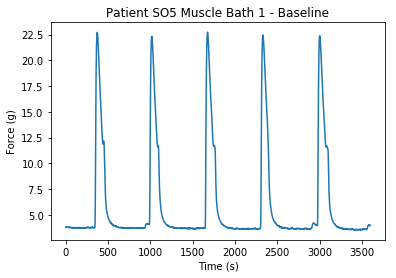

patientSO5_bath1_baseline.pdf


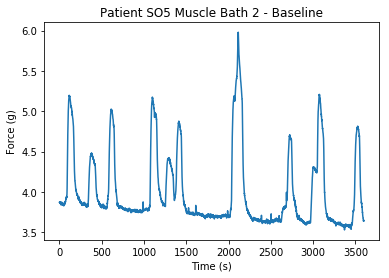

patientSO5_bath2_baseline.pdf


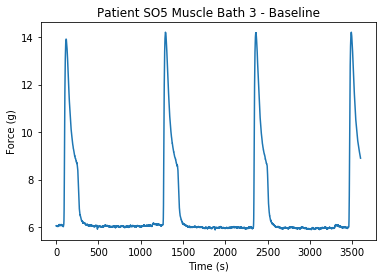

patientSO5_bath3_baseline.pdf


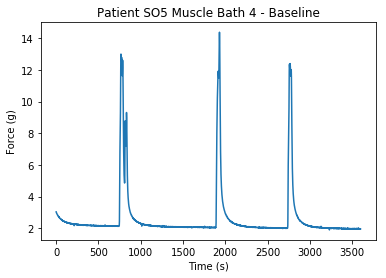

patientSO5_bath4_baseline.pdf


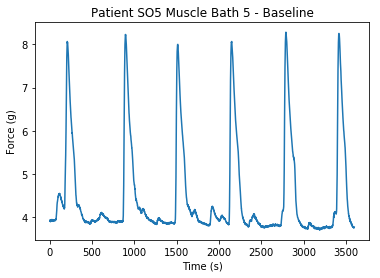

patientSO5_bath5_baseline.pdf


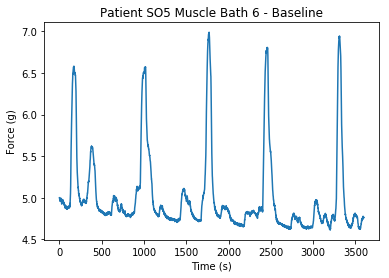

patientSO5_bath6_baseline.pdf


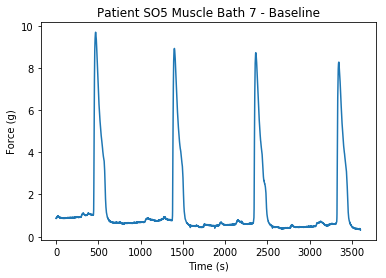

patientSO5_bath7_baseline.pdf


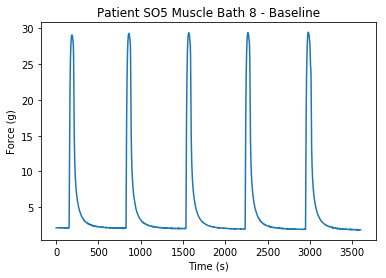

patientSO5_bath8_baseline.pdf


In [13]:
#plot the baseline contraction force data from
#for bath in df_ref['Bath Number']:
for i in range(len(baseline_array_list)):        
    bath = df_ref.iloc[i]["Bath Number"]
    #print("Muscle Bath",bath)
    f = plt.figure()
    plt.plot(np.array(baseline_array_list[i]))
    plt.title("Patient "+list(df_ref['Patient'])[i]+" Muscle Bath "+str(bath)+" - Baseline")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    plt.show()
    savestring = "patient"+(list(df_ref['Patient'])[i])+"_"+"bath"+str(bath)+"_baseline"+'.pdf'
    print(savestring)
    f.savefig(savestring,sep = '')

In [14]:
#loop through muscle baths in reference dataframe 
    #for each bath listed in the reference file, find the local max 
    #for the 1 hr of baseline in the muscle bath file
    #ask when baseline ended for each bath and count backwords 1hr
#create storage lists for outputs
locmax_list = []
fp_output_list = []
#for loop for peak analysis
#vary width variable for each study to tune the find_peaks function
width_var = float(input("input the width variable for find_peaks function:"))
for i in range(len(baseline_array_list)):           
    bath = df_ref.iloc[i]["Bath Number"]
    print("Muscle Bath",bath,":")
    #input the height cut off for peak analysis
    cutoff = float(input("input peak height cutoff:"))
    #vary width variable for each study to tune the find_peaks function
    #comment out width_var unless need to vary width for each bath
    #width_var = float(input("input the width variable for find_peaks function:"))
    fp_output = find_peaks(np.array(baseline_array_list[(i)]),height = cutoff, width = width_var)
    locmax = np.array(baseline_array_list[(i)])[fp_output[0]]
    locmax_list.append(locmax)
    fp_output_list.append(fp_output)
#width variable used for analysis of each study:    
#width_var = 8 for 2018_09_28_Myometrial_Contractility_Study_13_MB_1_8.tsv
#width_var = 35 for 2018_12_07_Myometrial_Contractility_Study_14_a.tsv
#width_var = 35 for 2018_12_13_Myometrial_Contractility_Study_15_MBa.tsv
#width_var = 40 for 2018_12_17_Myometrial_Contractility_Study_16_MBa.tsv
#width_var = 25 for 2019_01_28_Myometrial_Contractility_Study_17_MBa.tsv

input the width variable for find_peaks function:15
Muscle Bath 1 :
input peak height cutoff:15
Muscle Bath 2 :
input peak height cutoff:4.5
Muscle Bath 3 :
input peak height cutoff:10
Muscle Bath 4 :
input peak height cutoff:10
Muscle Bath 5 :
input peak height cutoff:6
Muscle Bath 6 :
input peak height cutoff:6
Muscle Bath 7 :
input peak height cutoff:6
Muscle Bath 8 :
input peak height cutoff:15


In [15]:
#processing find_peaks output
#assigning values from find peaks output to a list of local max indices 
locmax_indx_list = []
for i in range(len(fp_output_list)):
    locmax_indx_list.append(fp_output_list[i][0])
#assigning values from find peaks dictionary ouput to a list (to later be used with calculating duration of contractions, relaxation time, etc.)
locmax_dic_list = []
for i in range(len(fp_output_list)):
    locmax_dic_list.append(fp_output_list[i][1])

In [8]:
#?? peakutils.baseline


How long (sec) before a peak should the local min baseline begin?90
Duration (sec) of local min baseline:10
Muscle Bath 1


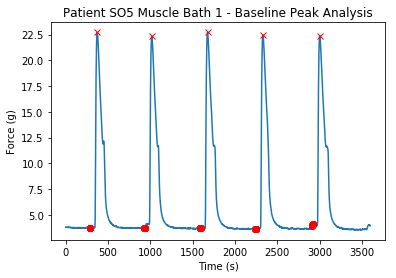

peakanalysisgraph_patientSO5_bath1_baseline.pdf
mean baseline force: [3.72608075 3.70965785 3.67994182 3.63730504 4.02135642]
Muscle Bath 2


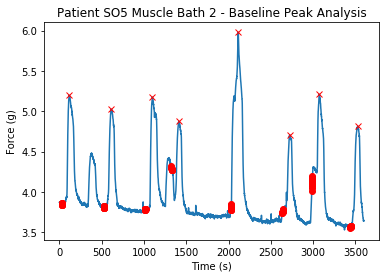

peakanalysisgraph_patientSO5_bath2_baseline.pdf
mean baseline force: [3.85155479 3.81011156 3.78190845 4.28732922 3.80498037 3.76211626
 4.11385455 3.5691316 ]
Muscle Bath 3


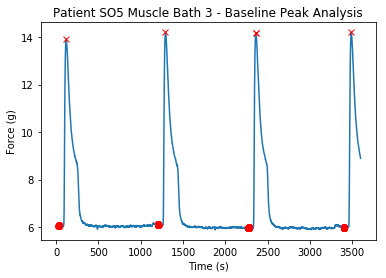

peakanalysisgraph_patientSO5_bath3_baseline.pdf
mean baseline force: [6.066782   6.10988557 5.97135263 5.98463333 5.98068834]
Muscle Bath 4


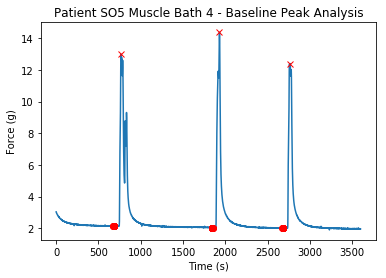

peakanalysisgraph_patientSO5_bath4_baseline.pdf
mean baseline force: [2.13294898 2.04025718 1.99161911]
Muscle Bath 5


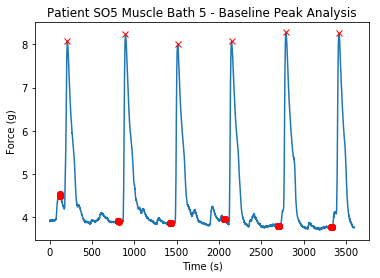

peakanalysisgraph_patientSO5_bath5_baseline.pdf
mean baseline force: [4.50644661 3.90631701 3.86761003 3.96148973 3.80595711 3.77143007]
Muscle Bath 6


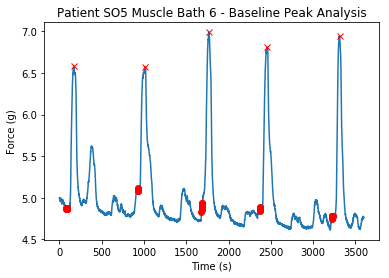

peakanalysisgraph_patientSO5_bath6_baseline.pdf
mean baseline force: [4.8711857  5.09687303 4.8991179  4.8655262  4.77244887]
Muscle Bath 7


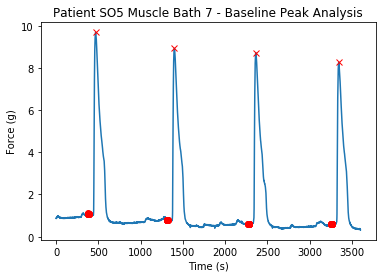

peakanalysisgraph_patientSO5_bath7_baseline.pdf
mean baseline force: [1.08950017 0.80959637 0.60504974 0.60549577]
Muscle Bath 8


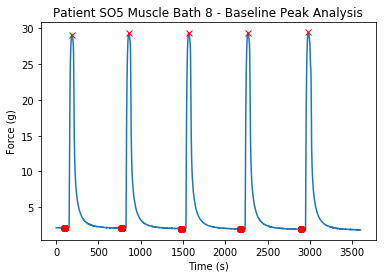

peakanalysisgraph_patientSO5_bath8_baseline.pdf
mean baseline force: [2.11024336 2.07762483 2.01029526 1.95878807 1.90559733]


In [41]:
#find a baseline/local minima range before each peak
#create an empty list to store start indices
startlist = []
#create an empty list to store end indices
endlist = []
#create an empty list to store an arrays of baseline values
base_val_list = []
#create an empty list to temporarily store baseline means
templist = []
#create an empty list to append array of baseline means
base = []
#
timebeforepeak = int(input("How long (sec) before a peak should the local min baseline begin?"))
baselineduration = int(input("Duration (sec) of local min baseline:"))
#loop through muscle baths
for x in range(len(df_ref)):
    bath = df_ref.iloc[x]["Bath Number"]
    #reset lists
    startlist = []
    endlist = []
    base_val_list = []
    templist = []
    print("Muscle Bath",bath)
    #loop through local max indices and calculate start point and end point for baseline calculation as an offset of this timepoint
    #store values in startlist and endlist
    for peak_time in locmax_indx_list[x]:
        #vary start time and end time in order to find proper baseline local min
        starttime = peak_time - timebeforepeak
        endtime = starttime + baselineduration
        if starttime < 0:
            starttime = 0
        if endtime < 0:
            endtime = 2
        startlist.append(starttime)
        endlist.append(endtime)
    #loop through contractions, calculate baseline values, assign values to spot in base_val_list
    for i in range(len(startlist)):
        baseline_values = peakutils.baseline(np.array(baseline_array_list[x])[startlist[i]:endlist[i]])
        base_val_list.append(baseline_values)
    #plot muscle baths with local min baseline and local max values highlighted     
    f = plt.figure()
    plt.plot(np.array(baseline_array_list[x])) 
    plt.title("Patient "+list(df_ref['Patient'])[x]+" Muscle Bath "+str(bath)+" - Baseline Peak Analysis")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    for counter, base_data in enumerate(base_val_list):
        plt.plot(np.arange(startlist[counter],endlist[counter]),base_data,'ro')
    for counter, peak in enumerate(locmax_list[x]):
        plt.plot(locmax_indx_list[x][counter],peak,'rx')
    plt.show()
    savestring = "peakanalysisgraph_" + "patient"+(list(df_ref['Patient'])[x])+"_"+"bath"+str(bath)+"_baseline"+'.pdf'
    print(savestring)
    f.savefig(savestring,sep = '')
    #average local min baseline data
    for base_val in base_val_list:
        #altered code to calculate the minimum value of baseline instead of average*******
        templist.append(base_val.mean())
        #templist.append(base_val.min())
        base_mean_array = np.array(templist)
    print("mean baseline force:",base_mean_array)
    #store local min baseline data in list
    base.append(base_mean_array)

In [10]:
#baseline peak force calculations
#create an empty list to store raw forces and titles
raw_force_list = []
forcetitles = []
#calculate baseline peak forces
for x in range(len(locmax_list)):
    #create a temporary list to store values for each muscle bath
    templist = []
    bath = df_ref.iloc[x]["Bath Number"]
    title = "bath" + str(bath) +" force (g)"
    forcetitles.append(title)
    for contract in range(len(locmax_list[x])):
        amp = (locmax_list[x][contract]-base[x][contract])
        templist.append(amp)
    raw_force_list.append(np.array(templist))
#make a dictionary out of titles and raw forces    
rawforcedic = dict(zip(forcetitles, raw_force_list))
#for each muscle bath calculate the average raw peak value during baseline
#this will be used for treatment peak normalization
#create empty storage lists 
basepeakmean = []
#for loop calculation 
for bath in range(len(raw_force_list)):
    basepeakmean.append(raw_force_list[bath].mean())  
#calculate cross-sectional area (CSA)
CSA_list = []
for bath in df_ref['Bath Number']:
    length = float(df_ref[df_ref['Bath Number']== bath]['Length (mm)'])
    mass = float(df_ref[df_ref['Bath Number']== bath]['Mass (mg)'])
    CSA = (length *1.056)/mass
    CSA_list.append(CSA)
#create an empty list to store raw forces and titles
norm_force_list = []
normtitles = []
#calculate CSA normalized baseline peak forces
for x in range(len(locmax_list)):
    #create a temporary list to store values for each muscle bath
    templist = []
    bath = df_ref.iloc[x]["Bath Number"]
    title = "bath" + str(bath) +" norm (g/CSA)"
    normtitles.append(title)
    for contraction in range(len(locmax_list[x])):
        norm = ((locmax_list[x][contraction]-base[x][contraction])/CSA_list[x])
        templist.append(norm)
    norm_force_list.append(np.array(templist))
#make a dictionary out of titles and raw forces    
normforcedic = dict(zip(normtitles, norm_force_list))
#calculate mean NORMALIZED force for each muscle bath and standard deviation
#may not be useful
#standard deviation may say something about stability of recovery
#create empty storage lists 
CSAmean = []
CSAstd = []
#for loop calculation
counter = 0    
for bath in df_ref['Bath Number']:
    CSAmean.append(norm_force_list[counter].mean())
    CSAstd.append(norm_force_list[counter].std())
    counter+=1

In [11]:
#sending baseline data to Excel spreadsheet

#create a dataframe to store raw force data
df_raw = pd.DataFrame.from_dict(rawforcedic, orient='index')
df_raw = df_raw.transpose()
#create a dataframe to store normalized data
df_norm = pd.DataFrame.from_dict(normforcedic, orient='index')
df_norm = df_norm.transpose()
#create output baseline dataframe
df_base_out = df_raw.join(df_norm)
df_base_out.head()
#determine which set of muscle baths were used
if df_ref["Bath Number"].max() > 16:
    computer = "comp3"
elif df_ref["Bath Number"].max() < 9:
    computer = "comp1"
else: 
    computer = "comp2"
#write baseline dataframe to Excel spreadsheet
#assume tissue in set of 8 muscle baths comes from the 
#same patient 
base_out_file = "Patient"+ list(df_ref['Patient'])[0] +"_baseline_"+computer+".xlsx"
df_base_out.to_excel(base_out_file)
print(base_out_file)

PatientSO5_baseline_comp1.xlsx


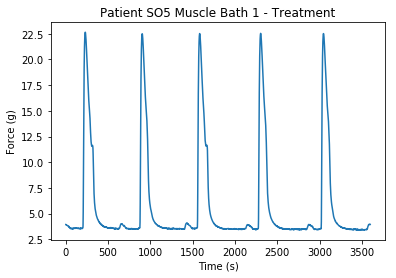

patientSO5_bath1_treatment.pdf


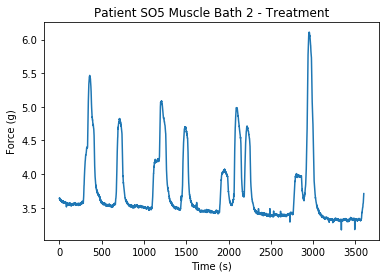

patientSO5_bath2_treatment.pdf


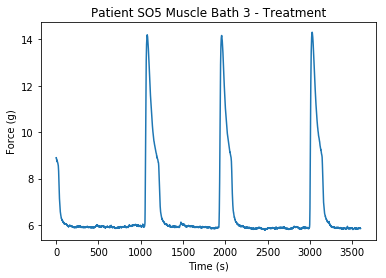

patientSO5_bath3_treatment.pdf


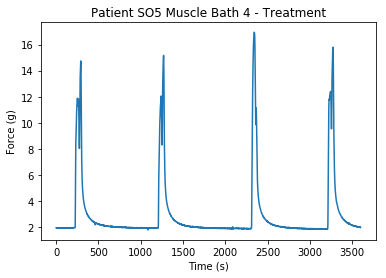

patientSO5_bath4_treatment.pdf


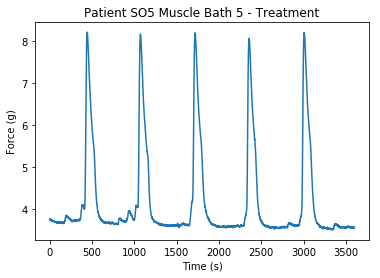

patientSO5_bath5_treatment.pdf


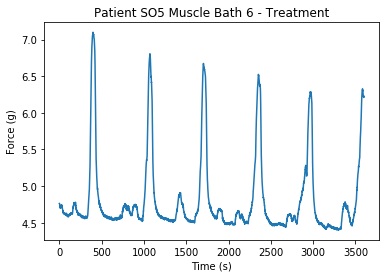

patientSO5_bath6_treatment.pdf


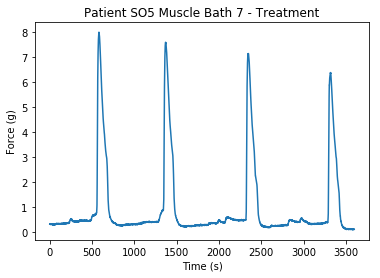

patientSO5_bath7_treatment.pdf


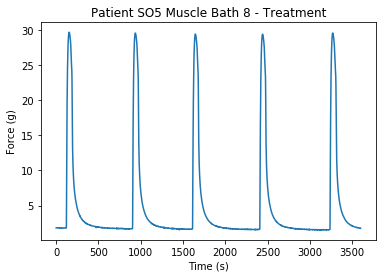

patientSO5_bath8_treatment.pdf


In [30]:
#create a placeholder list for storing arrays of treatment force data
treat_array_list = []
#loop through viable muscle baths in study file (df_file) and retrieve treatment force data
#send array of each muscle bath treatment force data to treat_array_list
count = 0
for bath in df_ref['Bath Number']:
    #print('Muscle Bath',bath,':')
    treatment_array = (df_file.loc[treat_time_list[count]:treat_time_list[count]+3599,Force_list[count]])
    treat_array_list.append(treatment_array)
    count += 1
#plot the treatment contraction force data
for i in range(len(treat_array_list)):        
    bath = df_ref.iloc[i]["Bath Number"]
    #print("Muscle Bath",bath)
    f = plt.figure()
    plt.plot(np.array(treat_array_list[i]))
    plt.title("Patient "+list(df_ref['Patient'])[i]+" Muscle Bath "+str(bath)+" - Treatment")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    plt.show()
    savestring = "patient"+(list(df_ref['Patient'])[i])+"_"+"bath"+str(bath)+"_treatment"+'.pdf'
    print(savestring)
    f.savefig(savestring,sep = '')

In [31]:
#peak analysis for 1 hour treatment
#create storage lists for outputs
treat_locmax_list = []
fp_treat_output_list = []
#for loop for peak analysis
#reuse the width variable defined earlier for baseline peak analysis
for i in range(len(treat_array_list)):           
    bath = df_ref.iloc[i]["Bath Number"]
    print("Muscle Bath",bath,":")
    #input the height cut off for peak analysis
    cutoff = float(input("input peak height cutoff:"))
    #vary width variable for each study to tune the find_peaks function
    #comment out width_var unless need to vary width for each bath
    #width_var = float(input("input the width variable for find_peaks function:"))
    fp_output = find_peaks(np.array(treat_array_list[(i)]),height = cutoff, width = width_var)
    locmax = np.array(treat_array_list[(i)])[fp_output[0]]
    treat_locmax_list.append(locmax)
    fp_treat_output_list.append(fp_output)
#width variable used for analysis of each study:    
#width_var = 8 for 2018_09_28_Myometrial_Contractility_Study_13_MB_1_8.tsv
#width_var = 35 for 2018_12_07_Myometrial_Contractility_Study_14_a.tsv
#width_var = 35 for 2018_12_13_Myometrial_Contractility_Study_15_MBa.tsv
#width_var = 40 for 2018_12_17_Myometrial_Contractility_Study_16_MBa.tsv
#width_var = 25 for 2019_01_28_Myometrial_Contractility_Study_17_MBa.tsv

Muscle Bath 1 :
input peak height cutoff:15
Muscle Bath 2 :
input peak height cutoff:4.3
Muscle Bath 3 :
input peak height cutoff:10
Muscle Bath 4 :
input peak height cutoff:10
Muscle Bath 5 :
input peak height cutoff:6
Muscle Bath 6 :
input peak height cutoff:6
Muscle Bath 7 :
input peak height cutoff:4
Muscle Bath 8 :
input peak height cutoff:15


In [42]:
#processing find_peaks output
#assigning values from find peaks output to a list of local max indices 
locmax_indx_treat_list = []
for i in range(len(fp_treat_output_list)):
    locmax_indx_treat_list.append(fp_treat_output_list[i][0])
#assigning values from find peaks dictionary ouput to a list (to later be used with calculating duration of contractions, relaxation time, etc.)
locmax_dic_treat_list = []
for i in range(len(fp_treat_output_list)):
    locmax_dic_treat_list.append(fp_treat_output_list[i][1])

How long (sec) before a peak should the local min baseline begin?600
Duration (sec) of local min baseline:550
Muscle Bath 1


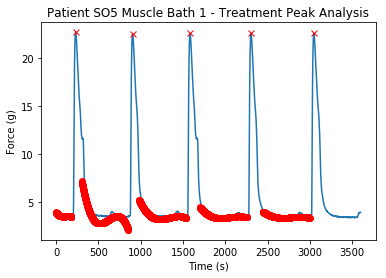

peakanalysisgraphs_patientSO5_bath1_treatment.pdf
mean baseline force: [3.59761394 3.53791617 3.61726372 3.5669118  3.50686704]
Muscle Bath 2


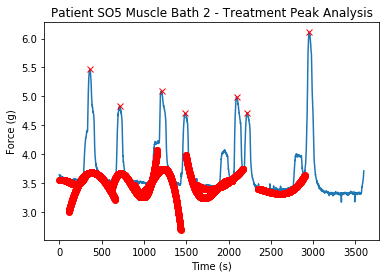

peakanalysisgraphs_patientSO5_bath2_treatment.pdf
mean baseline force: [3.52528919 3.49165242 3.4967036  3.47445029 3.43428886 3.48740365
 3.3827182 ]
Muscle Bath 3


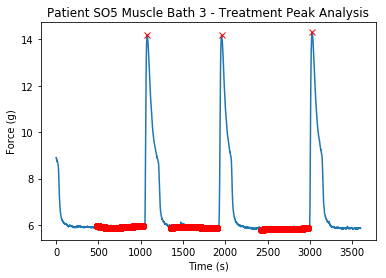

peakanalysisgraphs_patientSO5_bath3_treatment.pdf
mean baseline force: [5.91044518 5.89757206 5.83763888]
Muscle Bath 4


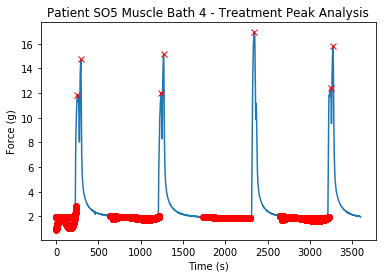

peakanalysisgraphs_patientSO5_bath4_treatment.pdf
mean baseline force: [1.9288236  1.55602854 1.9293217  1.85418214 1.8990868  1.90266022
 1.78252204]
Muscle Bath 5


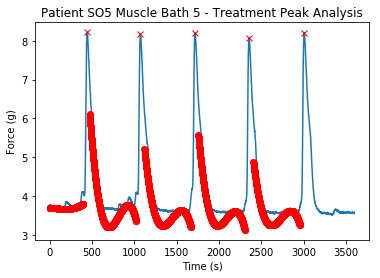

peakanalysisgraphs_patientSO5_bath5_treatment.pdf
mean baseline force: [3.69642498 3.75438114 3.60554267 3.64247957 3.56477039]
Muscle Bath 6


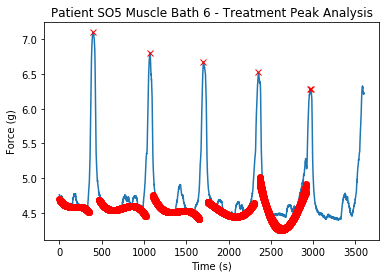

peakanalysisgraphs_patientSO5_bath6_treatment.pdf
mean baseline force: [4.59513962 4.57125286 4.53880549 4.52124786 4.47793745 4.48681341]
Muscle Bath 7


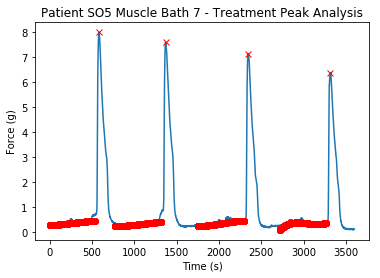

peakanalysisgraphs_patientSO5_bath7_treatment.pdf
mean baseline force: [0.36141302 0.31133014 0.34403471 0.32380317]
Muscle Bath 8


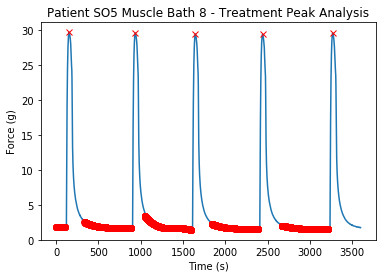

peakanalysisgraphs_patientSO5_bath8_treatment.pdf
mean baseline force: [1.81221525 1.88879886 1.94875534 1.74421238 1.67095633]


In [82]:
#find a baseline/local minima range before each peak
#create an empty list to store start indices
#startlist = []
#create an empty list to store end indices
#endlist = []
#create an empty list to store an arrays of baseline values
base_val_list = []
#create an empty list to temporarily store baseline means
templist = []
#create an empty list to append array of baseline means
base_treat = []
#
timebeforepeak = int(input("How long (sec) before a peak should the local min baseline begin?"))
baselineduration = int(input("Duration (sec) of local min baseline:"))
#loop through muscle baths
for x in range(len(df_ref)):
    bath = df_ref.iloc[x]["Bath Number"]
    #reset lists
    startlist = []
    endlist = []
    base_val_list = []
    templist = []
    print("Muscle Bath",bath)
    #loop through local max indices and calculate start point and end point for baseline calculation as an offset of this timepoint
    #store values in startlist and endlist
    for peak_time in locmax_indx_treat_list[x]:
        #vary start time and end time in order to find proper baseline local min
        starttime = peak_time - timebeforepeak
        endtime = starttime + baselineduration
        if starttime < 0:
            starttime = 0
        if endtime < 0:
            endtime = 2
        startlist.append(starttime)
        endlist.append(endtime)
        
    #loop through contractions, calculate baseline values, assign values to spot in base_val_list
    for i in range(len(startlist)):
        baseline_values = peakutils.baseline(np.array(treat_array_list[x])[startlist[i]:endlist[i]])
        base_val_list.append(baseline_values)
    #plot muscle baths with local min baseline and local max values highlighted     
    f = plt.figure()
    plt.plot(np.array(treat_array_list[x])) 
    plt.title("Patient "+list(df_ref['Patient'])[x]+" Muscle Bath "+str(bath)+" - Treatment Peak Analysis")
    plt.ylabel("Force (g)")
    plt.xlabel("Time (s)")
    for counter, base_data in enumerate(base_val_list):
        plt.plot(np.arange(startlist[counter],endlist[counter]),base_data,'ro')
    for counter, peak in enumerate(treat_locmax_list[x]):
        plt.plot(locmax_indx_treat_list[x][counter],peak,'rx')
    plt.show()
    
    savestring = "peakanalysisgraphs_" + "patient"+(list(df_ref['Patient'])[x])+"_"+"bath"+str(bath)+"_treatment"+'.pdf'
    print(savestring)
    f.savefig(savestring,sep = '')
    #average local min baseline data
    for base_val in base_val_list:
        #altered code to calculate the minimum value of baseline instead of average*******
        templist.append(base_val.mean())
        #templist.append(base_val.min())
        base_mean_array = np.array(templist)
    print("mean baseline force:",base_mean_array)
    #store local min baseline data in list
    base_treat.append(base_mean_array)

In [85]:
#treatment peak force calculations
#create an empty list to store the raw treatment peak values
treatpeakvals = []
treatpeaktitles = []
#calculate treatment peak forces
for mb in range(len(treat_locmax_list)):
    #create a temporary list to store each contraction peak for current muscle bath
    templist = []
    for contraction in range(len(treat_locmax_list[mb])):
        amplitude = (treat_locmax_list[mb][contraction]-base_treat[mb][contraction])
        templist.append(amplitude)
    treatpeakvals.append(np.array(templist))
    #create a title for these values. store them in a list 
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" force (g)"
    treatpeaktitles.append(title)
#normalizing to baseline function
#create an empty list to store the normalized treatment peak values and titles
normalized_treatment_peaks = []
normtreatpeaktitles = []
#normalize forces to baseline average peak force
for mb in range(len(treatpeakvals)):
    peaks_norm_2_base_function = treatpeakvals[mb]/basepeakmean[mb]
    normalized_treatment_peaks.append(peaks_norm_2_base_function)
    #normalized treatment peaks titles (for column labels in Excel file)
    bath = df_ref.iloc[mb]["Bath Number"]
    title = "bath" + str(bath) +" normalized to baseline"
    normtreatpeaktitles.append(title)
#make a dictionary out of titles and raw treatment contraction peaks    
treatpeakdic = dict(zip(treatpeaktitles, treatpeakvals))
#make a dictionary out of tiles and normalized treatment contraction peaks
treatnormpeakdic = dict(zip(normtreatpeaktitles, normalized_treatment_peaks))



In [86]:
#export treatment peak data to Excel spreadsheet
#create a dataframe to store raw force data
df_t_raw = pd.DataFrame.from_dict(treatpeakdic, orient='index')
df_t_raw = df_t_raw.transpose()
#create a dataframe to store normalized data
df_t_norm = pd.DataFrame.from_dict(treatnormpeakdic, orient='index')
df_t_norm = df_t_norm.transpose()
#create output baseline dataframe
df_treat_out = df_t_raw.join(df_t_norm)
df_treat_out.head()
#determine which set of muscle baths were used
if df_ref["Bath Number"].max() > 16:
    computer = "comp3"
elif df_ref["Bath Number"].max() < 9:
    computer = "comp1"
else: 
    computer = "comp2"
#write baseline dataframe to Excel spreadsheet
#assume tissue in set of 8 muscle baths comes from the 
#same patient 
treat_out_file = "Patient"+ list(df_ref['Patient'])[0] +"_treatment_"+computer+".xlsx"
df_treat_out.to_excel(treat_out_file)
print(treat_out_file)


PatientSO5_treatment_comp1.xlsx


In [132]:
print(treat_array_list[0])
print(locmax_indx_treat_list)

Experiment Time
15489.0    3.945
15490.0    3.944
15491.0    3.931
15492.0    3.928
15493.0    3.924
15494.0    3.907
15495.0    3.906
15496.0    3.906
15497.0    3.900
15498.0    3.885
15499.0    3.891
15500.0    3.885
15501.0    3.867
15502.0    3.878
15503.0    3.873
15504.0    3.866
15505.0    3.843
15506.0    3.845
15507.0    3.842
15508.0    3.835
15509.0    3.834
15510.0    3.835
15511.0    3.828
15512.0    3.816
15513.0    3.813
15514.0    3.804
15515.0    3.799
15516.0    3.795
15517.0    3.792
15518.0    3.777
           ...  
19059.0    3.684
19060.0    3.711
19061.0    3.752
19062.0    3.786
19063.0    3.800
19064.0    3.821
19065.0    3.842
19066.0    3.860
19067.0    3.867
19068.0    3.891
19069.0    3.910
19070.0    3.927
19071.0    3.913
19072.0    3.930
19073.0    3.944
19074.0    3.937
19075.0    3.939
19076.0    3.950
19077.0    3.948
19078.0    3.959
19079.0    3.960
19080.0    3.962
19081.0    3.962
19082.0    3.955
19083.0    3.971
19084.0    3.953
19085.0    3.96

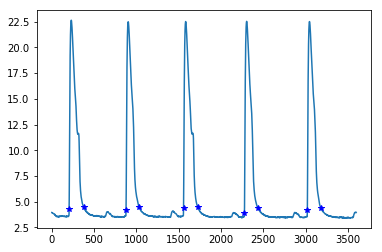

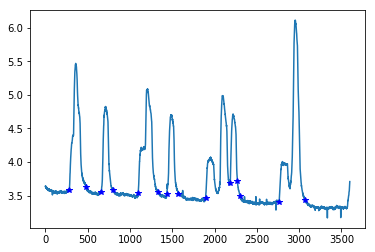

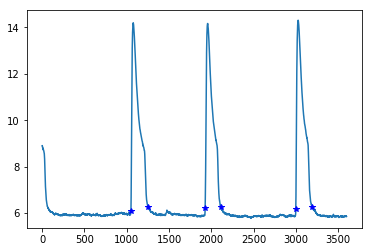

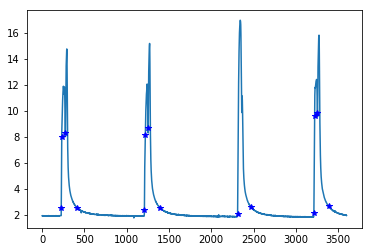

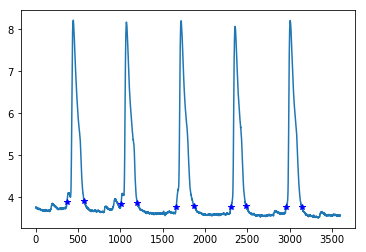

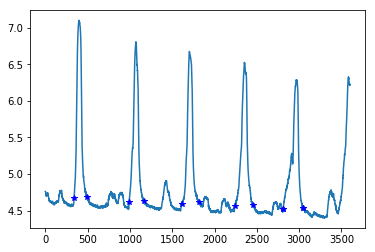

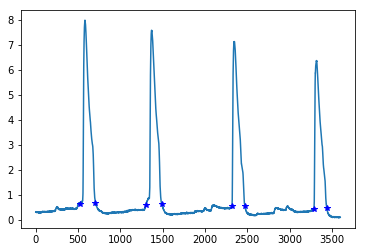

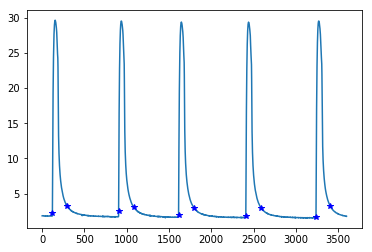

[array([170, 155, 167, 157, 159]), array([200, 136, 232, 135, 408,  84, 305]), array([200, 185, 196]), array([ 42, 189,  31, 188, 160,  33, 176]), array([205, 192, 208, 180, 182]), array([152, 170, 206, 215, 237, 237]), array([180, 189, 152, 149]), array([176, 177, 182, 180, 170])]


In [169]:
#calculate duration of contractions
peakduration = []
for mb in range(len(treat_array_list)):
    templist = []
    plt.plot(np.array(treat_array_list[mb]))
    widths = peak_widths(treat_array_list[mb],locmax_indx_treat_list[mb],0.95)
    for contraction in range(len(treat_locmax_list[mb])):
        leftx = (int(widths[2][contraction]))
        lefty = np.array(treat_array_list[mb])[leftx]
        plt.plot(leftx,lefty,'b*')
        rightx = (int(widths[3][contraction]))
        righty = np.array(treat_array_list[mb])[rightx]
        plt.plot(rightx,righty,'b*')
        templist.append(rightx-leftx)
    plt.show()
    peakduration.append(np.array(templist))

print(peakduration)

In [ ]:
#calculate relaxation time


In [229]:
#4 parameters
#1. peak force or amplitude
#2. frequency or contractions/hour
#3. duration of contractions
#4. relaxation time

In [230]:
comments_file.close()